# Mood-RL Demonstrations

Based on [Eldar & Niv (2015)](https://www.nature.com/articles/ncomms7149): *Interaction between emotional state and learning underlies mood instability*. 

## Reinforcement Learning Model
In traditional reinforcement learning models, the expected value ($v$) of a stimulus is updated according to a reward prediction error ($\delta$), which reflects the difference between the actual reward obtained ($r$) and the expected value ($\delta = r - v$). This simple framework has proved successful in explaining a wide range of behavioral and neural data. 

To account for effects of mood on valuation, the model is modified to compute predictions errors with respect to *perceived reward* rather than actual reward: 

> $\delta = r_\text{perceived} - v$

where perceived reward ($r_\text{perceived}$) is different from actual reward in that it reflects the biasing effect of mood ($m$):

> $r_\text{perceived} = r \cdot f^m$

Here, $m \in (-1,1)$ where a good mood is indicated by $0 < m < 1$, and a bad mood is indicated by $-1 < m < 0$). $f$ is a positive constant that indicates the direction and extent of the mood bias. If $f=1$, moos does not bias the perception of reward. If $f>1$, mood exerts positive feedback as reward is perceived as larger in a good mood and smaller in a bad mood. Conversely, if $0 < f < 1$, mood exerts negative feedback as reward is perceived as smaller in a good mood and larger in a bad mood. 

To model the effects of unexpected outcomes on mood, mood is assumed to reflect recent prediction-error history ($h$), tracked using a step-size parameters $\eta_h$:

> $h = h + \eta_h (\delta - h)$

and is constrained to -1 and 1 by a sigmoid function:

> $m = \text{tanh} \ h$

Similar to traditional reinforcement learning models, expected values are updated after every trial according to the reward prediction error with a step-size (learning rate) parameter $\eta_v$:

> $v = v + \eta_v \delta$

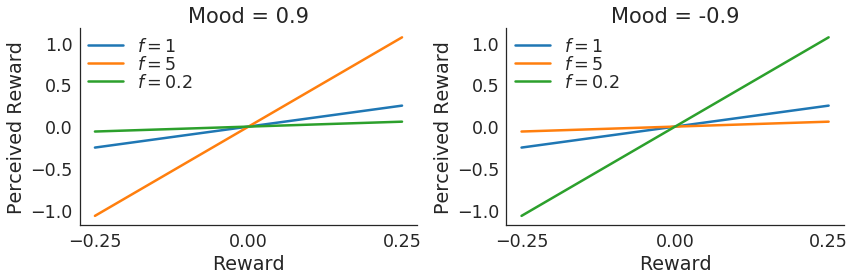

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Define bias function and rewards.
bias = lambda x, f, m: x * f ** m
reward = np.linspace(-0.25, 0.25, 101)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot.
for ax, m in zip(axes, [0.9, -0.9]):
    
    for f in [1, 5, 0.2]:
        
        ax.plot(reward, bias(reward, f, m), lw=2.5, label=r'$f = %s$' %f)
    
    ax.set(xticks=np.linspace(reward.min(),reward.max(),3), xlabel='Reward',
           ylabel='Perceived Reward', title='Mood = %s' %m)
    ax.legend(loc=2, borderpad=0, labelspacing=0)
    
sns.despine()
plt.tight_layout()

## Task Design
For complete details of the task design, please see the original manuscript. Of relevance here are three task design features:

1. **Slot machine comparison balance:** trial types are balanced within block. In other words, trials wherein 20% and 40% probability machines are compared are presented the same number of times as trials wherein 20% and 60% probability machines are compared.
2. **Within-subject trial randomization:** trial presentation order are randomized within block. In other words, the likelihood of observing any pair of trials (e.g. *20% vs. 40% probability* then *20% vs. 60% probability*) is approximately equal across participants. Within participants, this balancing is not guaranteed. 
3. **Between-subject trial randomization:** trials are randomized across participants. In other words, every participant will observe a unique order of presented trials. 
4. **Outcome randomization:** rewards are truly randomized. In other words, though the average reward probability of each machine across participants is as designed (i.e. 20%, 40%, 60%), there is variability within participants' experience (e.g. 15%, 45%, 65%).

## Demonstrations

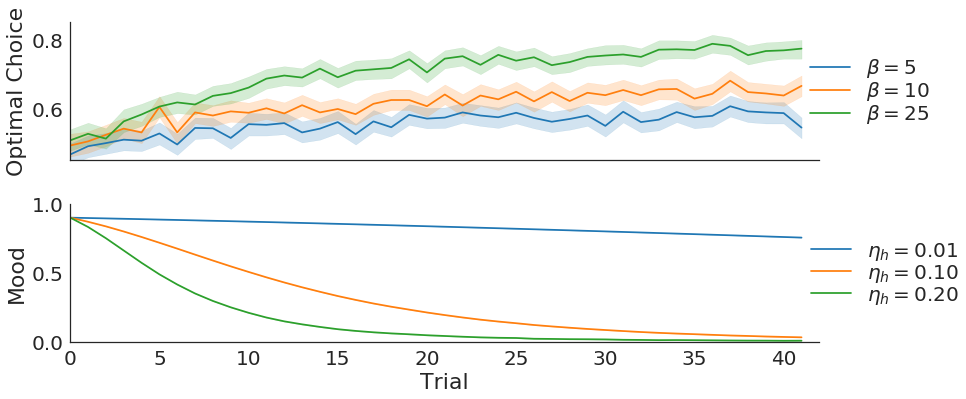

In [2]:
from scripts.simulations import *
sns.set_context('notebook', font_scale=2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters, by column:
## - Inverse temperature (beta)
## - Learning rate (eta_v)
## - Mood volatility (eta_h)
## - Bias function (f)
parameters = [(5,  0.2, 0.01, 1.0),
              (10, 0.2, 0.1, 1.0),
              (25, 0.2, 0.2, 1.0)]

## Initial values.
Q = 0.0
M = 0.9

## Task parameters.
probabilities = (0.2, 0.4, 0.6)
reward = 0.25
n_trials = 42

## Simulation parameters.
n_simulations = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
choices = np.zeros((n_simulations, len(parameters), n_trials))
moods = np.zeros_like(choices)

## Main loop.
for i in range(n_simulations):
    
    ## Simulate slot machine game.
    X, R = slot_machine_game(n_trials=n_trials, probabilities=probabilities, reward=reward)

    for j, params in enumerate(parameters):

        ## Initialize agent.
        agent = MoodyAgent(*params)
    
        ## Play block of slot machine game.
        Y, M = agent.simulate(X, R, Q=Q, M=M)
        moods[i,j] = M

        ## Compute optimal choices.
        choices[i,j] = optimal_choice(Y, X)

## Convert choices/moods to DataFrame.
choices = DataFrame3d(choices, major_axis=[r'$\beta = %s$' %params[0] for params in parameters])
moods = DataFrame3d(moods, major_axis=[r'$\eta_h = %0.2f$' %params[2] for params in parameters])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas. 
fig, axes = plt.subplots(2,1,figsize=(12,6))
palette = sns.color_palette(n_colors=len(parameters))

## Plot optimal choice / mood.
sns.lineplot('minor', 'value', 'major', data=choices, palette=palette, ax=axes[0])
sns.lineplot('minor', 'value', 'major', data=moods, palette=palette, ax=axes[1])

## Add info.
axes[0].set(xlim=(0,n_trials), xticks=[], xlabel='', ylim=(0.45, 0.85), ylabel='Optimal Choice')
axes[0].legend(loc=7, bbox_to_anchor=(1.16,0.5), borderpad=0, labelspacing=0)
axes[1].set(xlim=(0,n_trials), xlabel='Trial', ylim=(0,1), ylabel='Mood')
axes[1].legend(loc=7, bbox_to_anchor=(1.2,0.5), borderpad=0, labelspacing=0)

sns.despine()
plt.tight_layout()

## Identifiability Issues

Take the formulas from above and plug them in to arrive at one equation: 

> $v_{i+1} = v_i + \eta_v (r_i \cdot f^m - v_i)$

Assuming fixed values and rewards, $v_i$ and $r_i$, for trial $i$, let us find where different values of the parameters give rise to the same learning updates:

> $ v + \eta_1 (r \cdot f_1^m - v) = v + \eta_2 (r \cdot f_2^m - v) $ 

Simplified: 

> $ \eta_1 (r \cdot f_1^m - v) = \eta_2 (r \cdot f_2^m - v) $ 

Multiply it out:

> $ r f_1^m \eta_1 - v \eta_1 = r f_2^m \eta_2 - v \eta_2$

Trade it out:

> $ r f_1^m \eta_1 - r f_2^m \eta_2  = v \eta_1 - v \eta_2$

Pull out:

> $ r(f_1^m \eta_1 - f_2^m \eta_2 ) = v( \eta_1 - \eta_2 ) $

Only simplifying assumption we make, assume $v = 0$ at trial $i=1$: 

> $ f_1^m \eta_1 - f_2^m \eta_2 = 0 $

> $ f_1^m \eta_1 = f_2^m \eta_2 $

> $ \frac{\eta_1}{\eta_2} = \frac{f_2^m}{f_1^m} $

> $ log(\eta_1) - log(\eta_2) = m \cdot log(f_2) - m \cdot log(f_1)$

> $ log(\eta_1) - log(\eta_2) = m (log(f_2) - log(f_1))$

> $ \frac{log(\eta_1) - log(\eta_2)}{log(f_2) - log(f_1))} = m $

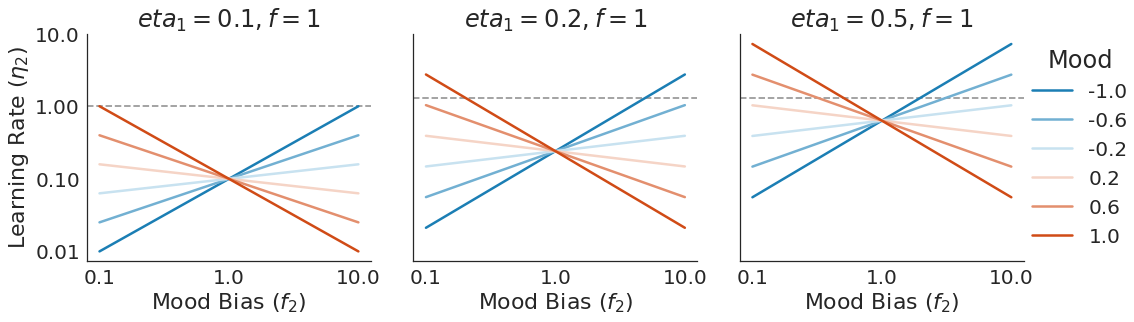

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Parameters (eta_v, f).
parameters = [(0.1, 1), (0.2, 1), (0.5, 1)]

## Sampling space.
f_2 = np.logspace(-1,1,101)
moods = np.linspace(-1,1,6)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define solver function.
solver = lambda eta_1, f_1, f_2, m: np.exp( np.log(eta_1) - m*(np.log(f_2) - np.log(f_1)) )

## Initialize canvas.
fig, axes = plt.subplots(1, len(parameters), figsize=(15,5), sharex=True, sharey=True)
colors = sns.diverging_palette(240,20,n=6,s=95)

## Main loop.
for i, ax, params in zip(np.arange(axes.size), axes, parameters):
    
    ## Iterate over moods.
    for m, color in zip(moods, colors):
        
        ## Compute eta_2.
        eta_2 = solver(*params, f_2, m)
        
        ## Plot.
        ax.plot(f_2, eta_2, lw=2.5, color=color, label=m)
        
    ## Add info.
    ax.hlines(1, 0.08, 12.5, linestyle='--', alpha=0.4)
    ax.set(xscale='log', yscale='log')
    ax.set(xlim=(0.08, 12.5), xlabel=r'Mood Bias ($f_2$)', xticks=np.logspace(-1,1,3),
           xticklabels=['0.1', '1.0', '10.0'], yticklabels=[], 
           title=r'$eta_1 = %s, f = %s$' %params)

## Finalize plot.
axes[0].set(yticks=np.logspace(-2,1,4), yticklabels=['0.01','0.10','1.00','10.0'], 
            ylabel=r'Learning Rate ($\eta_2$)')
axes[-1].legend(loc=7, bbox_to_anchor=(1.4,0.5), borderpad=0, labelspacing=0.5, title='Mood')
    
sns.despine()
plt.tight_layout()

**Summary:** there are many equivalent sets of parameters that achieve similar updating to the simplest RL model. In general, higher mood bias requires a counteracting lower learning rate for positive mood; this is reversed for negative mood. 

This risk is mitigated by a dynamic mood, especially when mood changes sign.

## Dual Learning Rates

Take the formulas from above and plug them in to arrive at one equation: 

> $v_{i+1} = v_i + \eta_v (r_i \cdot f^m - v_i)$

Note a pattern with rewards:

> $v_{i+1} \begin{cases} v_i + \eta_v (r_i \cdot f^m - v_i) \ \ \ if \ r_i \neq 0 \\
v_i - \eta_v v_i \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ if \ r_i = 0 \end{cases} $

This may be equivalent to an RL model with two learning rates, $\eta_+$ and $\eta_-$.

> $v_{i+1} \begin{cases} v_i + \eta_+ (r_i - v_i) \ \ \ if \ r_i > 0 \\
v_i - \eta_- v_i \ \ \ \ \ \ \ \ \ \ \ \ \ \ if \ r_i = 0 \end{cases} $

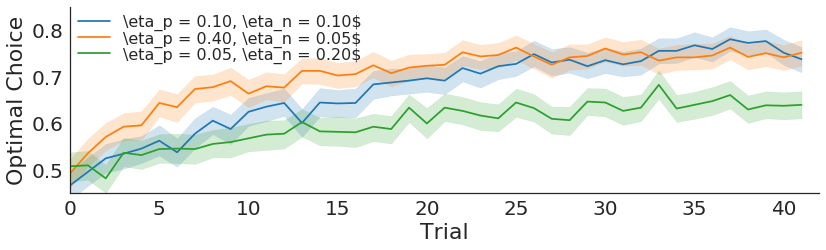

In [4]:
from scripts.simulations import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters, by column:
## - Inverse temperature (beta)
## - Learning rate, positive (eta_p)
## - Learning rate, negative (eta_n)
parameters = [(25, 0.10, 0.10),
              (25, 0.40, 0.05),
              (25, 0.05, 0.20)]

## Initial values.
Q = 0.0

## Task parameters.
probabilities = (0.2, 0.4, 0.6)
reward = 0.25
n_trials = 42

## Simulation parameters.
n_simulations = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
choices = np.zeros((n_simulations, len(parameters), n_trials))

## Main loop.
for i in range(n_simulations):
    
    ## Simulate slot machine game.
    X, R = slot_machine_game(n_trials=n_trials, probabilities=probabilities, reward=reward)

    for j, params in enumerate(parameters):

        ## Initialize agent.
        agent = DualLearningAgent(*params)
    
        ## Play block of slot machine game.
        Y = agent.simulate(X, R, Q=Q)

        ## Compute optimal choices.
        choices[i,j] = optimal_choice(Y, X)

## Convert choices to DataFrame.
major_axis = [r'\eta_p = %0.2f, \eta_n = %0.2f$' %params[1:] for params in parameters]
choices = DataFrame3d(choices, major_axis=major_axis)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas. 
fig, ax = plt.subplots(1,1,figsize=(12,4))
palette = sns.color_palette(n_colors=len(parameters))

## Plot optimal choice / mood.
sns.lineplot('minor', 'value', 'major', data=choices, palette=palette, ax=ax)

## Add info.
ax.set(xlim=(0,n_trials), xlabel='Trial', ylim=(0.45, 0.85), ylabel='Optimal Choice')
ax.legend(loc=2, borderpad=0, labelspacing=0, fontsize=16)

sns.despine()
plt.tight_layout()

## How similar are these models?

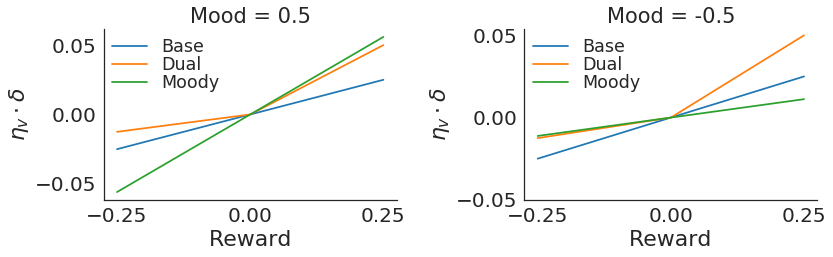

In [5]:
## Define RL functions.
base = lambda eta_v, q, r: eta_v * (r - q)
dual = lambda eta_p, eta_n, q, r: np.where( r - q > 0, eta_p * (r - q), eta_n * (r - q) )
moody = lambda eta_v, f, m, q, r: eta_v * ( r * f ** m - q )
 
## Define reward spectrum.
r = np.linspace(-0.25, 0.25, 101)
q = 0

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.set_context('notebook', font_scale=1.75)

## Plot.
for ax, m in zip(axes, [0.5, -0.5]):
    
    ## Plot.
    ax.plot( r, base(0.1, q, r), lw=2.5, label='Base')
    ax.plot( r, dual(0.2, 0.05, q, r), lw=2.5, label='Dual')
    ax.plot( r, moody(0.1, 5, m, q, r), lw=2.5, label='Moody')

        
    ax.set(xticks=np.linspace(r.min(),r.max(),3), xlabel='Reward', yticks=[-0.05,0.00,0.05],
           ylabel=r'$\eta_v \cdot \delta$', title='Mood = %s' %m)
    ax.legend(loc=2, borderpad=0, labelspacing=0)
    
sns.despine()
plt.tight_layout()

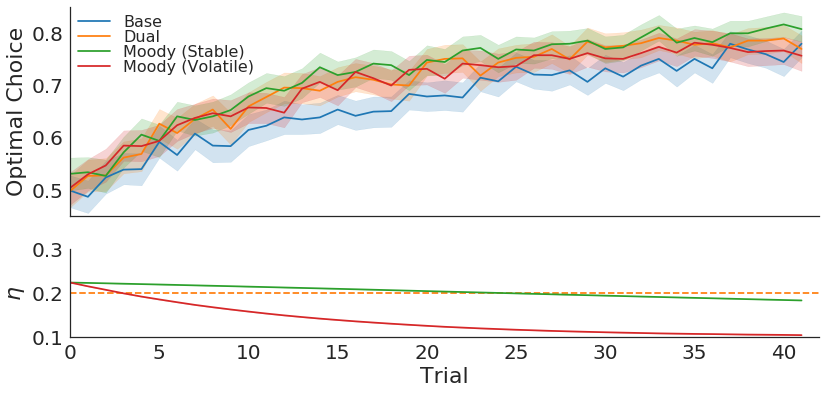

In [6]:
from scripts.simulations import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters.
base_agent = DualLearningAgent(beta=25, eta_p=0.1, eta_n=0.1)
dual_agent = DualLearningAgent(beta=25, eta_p=0.2, eta_n=0.05)
mood_agent_s = MoodyAgent(beta=25, eta_v=0.1, eta_h=0.01, f=5)
mood_agent_v = MoodyAgent(beta=25, eta_v=0.1, eta_h=0.1, f=5)

## Initial values.
Q = 0.0
M = 0.5

## Task parameters.
probabilities = (0.2, 0.4, 0.6)
reward = 0.25
n_trials = 42

## Simulation parameters.
n_simulations = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
choices = np.zeros((n_simulations, 4, n_trials))
moods = np.zeros((n_simulations, 2, n_trials))

## Main loop.
for i in range(n_simulations):
    
    ## Simulate slot machine game.
    X, R = slot_machine_game(n_trials=n_trials, probabilities=probabilities, reward=reward)

    ## Base agent.
    Y = base_agent.simulate(X, R, Q=Q)
    choices[i,0] = optimal_choice(Y, X)
    
    ## Dual learning agent.
    Y = dual_agent.simulate(X, R, Q=Q)
    choices[i,1] = optimal_choice(Y, X)
    
    ## Moody agent (stable).
    Y, m = mood_agent_s.simulate(X, R, Q=Q, M=M)
    choices[i,2] = optimal_choice(Y, X)
    moods[i,0] = m
    
    ## Moody agent (volatile).
    Y, m = mood_agent_v.simulate(X, R, Q=Q, M=M)
    choices[i,3] = optimal_choice(Y, X)
    moods[i,1] = m

## Convert choices to DataFrame.
major_axis = ['Base', 'Dual', 'Moody (Stable)', 'Moody (Volatile)']
choices = DataFrame3d(choices, major_axis=major_axis)

## Compute learning rates.
learning_rates = np.zeros_like(moods)
for i, agent in enumerate([mood_agent_s, mood_agent_v]):
    learning_rates[:,i] = agent.info['eta_v'] * agent.info['f'] ** moods[:,i]
learning_rates = DataFrame3d(learning_rates, major_axis=major_axis[-2:])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas. 
fig = plt.figure(figsize=(12,6))
sns.set_context('notebook', font_scale=2.00)
palette = sns.color_palette(n_colors=4)

## Plot optimal choice.
ax = plt.subplot2grid((3,1),(0,0),rowspan=2)
sns.lineplot('minor', 'value', 'major', data=choices, palette=palette, ax=ax)
ax.set(xlim=(0,n_trials), xticks=[], xlabel='', ylim=(0.45, 0.85), ylabel='Optimal Choice')
ax.legend(loc=2, borderpad=0, labelspacing=0, fontsize=16)

## Plot learning rates.
ax = plt.subplot2grid((3,1),(2,0))
sns.lineplot('minor', 'value', 'major', data=learning_rates, palette=palette[-2:], ax=ax)
ax.hlines(dual_agent.info['eta_p'], 0, n_trials, linestyle='--', color=palette[1])
ax.set(xlim=(0,n_trials), xlabel='Trial', ylim=(0.1, 0.3), ylabel=r'$\eta$')
ax.legend_.set_visible(False)

sns.despine()
plt.tight_layout()